<a href="https://colab.research.google.com/github/brendanfoo/predict_refugee_count/blob/main/RF_ensemble_for_m_h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# imports / data prep

In [ ]:
# Imports
import pandas as pd
import geopandas as gpd
import random
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import confusion_matrix
import seaborn
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import LabelEncoder

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
fullmerge = pd.read_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/FULLMERGE.csv').iloc[:, 1:]
fullmerge.head()

,ISO3,IDPs from Event,econ,gov,soc,cap,eco,exp,food,hab,...,Area,Began,Ended,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes"
0,AFG,270,0.178628,0.172592,0.335777,0.757451,0.507907,0.480512,0.580916,0.537736,...,14653.47,2013-04-23,2013-04-29,Torrential Rain,1.0,6.0,11.384192,"31,098,161",47.7,"-67,219"
1,AFG,740,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,83722.34,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115"
2,AFG,244,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,83722.34,2014-04-20,2014-05-16,Torrential Rain,1.5,26.0,14.998823,"31,809,829",48.8,"-58,115"
3,AFG,5775,0.201495,0.193780,0.341216,0.732208,0.503280,0.480512,0.576083,0.539343,...,44203.93,2014-06-03,2014-06-10,Heavy Rain,1.5,7.0,13.047944,"31,809,829",48.8,"-58,115"
4,AFG,46380,0.210240,0.158260,0.354043,0.711203,0.509198,0.480512,0.615954,0.534952,...,184396.90,2018-05-09,2018-05-22,Torrential Rain,1.5,13.0,15.095260,"34,907,481",53.5,"-21,703"


<ipython-input-4-46dada2d6405>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cat['binnedIDPs'] = pd.qcut(cat['IDPs from Event'], 3, duplicates = 'drop', labels = False).astype(str) # BINS AGNOSTIC OF COUNTRY


<Axes: >

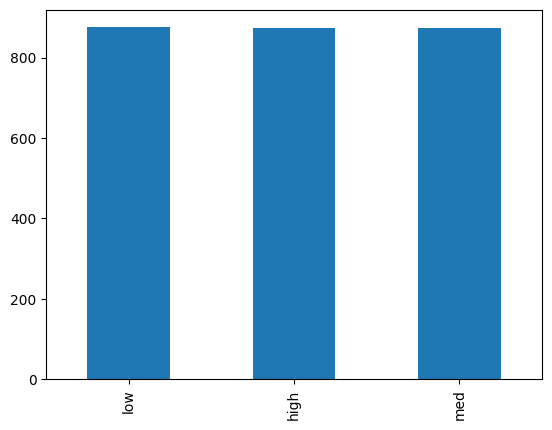

In [ ]:
cat = fullmerge.copy(deep = True).drop(columns = ['Ended'])
cat = cat.dropna()
#cat['binnedIDPs'] = cat.groupby('ISO3')['IDPs from Event'].apply(lambda x: pd.qcut(x, 3, duplicates = 'drop', labels = False).astype(str)) # BINS RELATIVE TO COUNTRY
cat['binnedIDPs'] = pd.qcut(cat['IDPs from Event'], 3, duplicates = 'drop', labels = False).astype(str) # BINS AGNOSTIC OF COUNTRY
# cat = cat.drop(columns = ['IDPs from Event'])
cat = cat[~(cat['binnedIDPs'] == 'nan')]
def label(x):
  if x == '0':
    return 'low'
  if x == '1':
    return 'med'
  if x == '2':
    return 'high'
  return 'damn it'
cat['binnedIDPs'] = cat['binnedIDPs'].apply(label)
cat['binnedIDPs'].value_counts().plot(kind='bar')

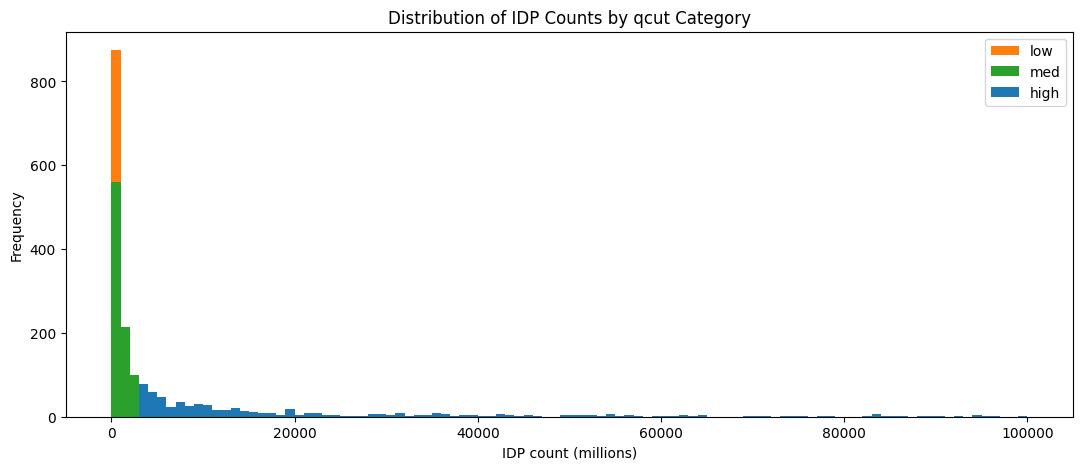

In [ ]:
# histogram of the distribution of IDP counts color coded
# by there qcut category for the categorical models

cat_copy = cat.copy()

cat_copy = cat_copy[cat_copy ['IDPs from Event'] <= 100000]
cat_copy.head()

plt.rcParams["figure.figsize"] = (13,5)

cat_copy.pivot(columns='binnedIDPs', values='IDPs from Event').plot.hist(bins=100,alpha=1)

# Order legend from low to high
handles, labels = plt.gca().get_legend_handles_labels()
order = [1,2,0]

# Add legend and title to plot
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])
plt.title('Distribution of IDP Counts by qcut Category')
plt.xlabel('IDP count (millions)')
#plt.ylim(top = 200)

plt.show()

In [ ]:
cat.head()

,ISO3,IDPs from Event,econ,gov,soc,cap,eco,exp,food,hab,...,Area,Began,MainCause,Severity,Duration,Magnitude,Population,Population Density (People per Sq. Km.),"Net international migrants, both sexes",binnedIDPs
31,AGO,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,12133.31,2015-03-09,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",high
32,AGO,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,10252.79,2015-03-09,Torrential Rain,1.5,14.0,12.279828,"27,292,819",21.9,"14,473",high
33,AGO,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,12133.31,2015-03-09,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",med
34,AGO,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,10252.79,2015-03-09,Torrential Rain,1.5,14.0,12.279828,"27,292,819",21.9,"14,473",med
35,AGO,483,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,...,12133.31,2015-03-09,Torrential Rain,1.5,14.0,12.448232,"27,292,819",21.9,"14,473",med


In [ ]:
cat['Began'] = pd.to_datetime(cat['Began'])

In [ ]:
month_ohe = pd.get_dummies(cat['Began'].dt.month, drop_first = True)

#iso_ohe = pd.get_dummies(cat['ISO3'], drop_first = True)

In [ ]:
cat = cat.drop(columns = ['ISO3', 'Began'])
cat = cat.join(month_ohe)
#cat = cat.join(iso_ohe)

In [ ]:
cat['MainCause'] = cat['MainCause'].str.lower()

In [ ]:
cat['Storms'] = np.zeros(cat.shape[0])
cat['DamBreak'] = np.zeros(cat.shape[0])
cat['Rain'] = np.zeros(cat.shape[0])
cat['Melting'] = np.zeros(cat.shape[0])
cat['TidesTsunami'] = np.zeros(cat.shape[0])

In [ ]:
for index, row in cat.iterrows():
  maincause = row['MainCause']
  if ('tropical' in maincause) or ('storm' in maincause) or ('monsoon' in maincause) or ('cyclone' in maincause) or ('typhoon' in maincause):
    cat.loc[index, 'Storms'] = 1
  if ('dam' in maincause):
    cat.loc[index, 'DamBreak'] = 1
  if ('rain' in maincause):
    cat.loc[index, 'Rain'] = 1
  if ('snow' in maincause) or ('ice' in maincause) or ('glacier' in maincause) or ('jökulhlaup' in maincause):
    cat.loc[index, 'Melting'] = 1
  if ('tide' in maincause) or ('tsunami' in maincause):
    cat.loc[index, 'TidesTsunami'] = 1

In [ ]:
cat = cat.drop(columns = ['MainCause'])

In [ ]:
for col in cat.columns:
  print(col, end=' | ')

IDPs from Event | econ | gov | soc | cap | eco | exp | food | hab | health | infra | sens | Area | Severity | Duration | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | binnedIDPs | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Storms | DamBreak | Rain | Melting | TidesTsunami | 

In [ ]:
cat = cat.replace(',','', regex=True)
cat = cat.replace('--','0', regex=True)
cat.shape

(2622, 36)

In [ ]:
cat = cat.dropna()
cat.shape

(2622, 36)

In [ ]:
target = cat[['binnedIDPs']]
cat = cat.drop(columns = ['binnedIDPs'])
cat['binnedIDPs'] = target
cat.head()

,IDPs from Event,econ,gov,soc,cap,eco,exp,food,hab,health,...,9,10,11,12,Storms,DamBreak,Rain,Melting,TidesTsunami,binnedIDPs
31,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
32,3920,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,high
33,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med
34,1192,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med
35,483,0.139844,0.308112,0.18999,0.734707,0.54614,0.543063,0.571513,0.680376,0.583568,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,med


In [ ]:
cat = cat.drop(columns = ['Area', 'Severity', 'Duration'])
catcop = cat.copy(deep=True)
cat = cat.drop(columns = ['IDPs from Event'])

In [ ]:
cat.to_csv('/content/drive/MyDrive/210RefugeeMoves/datasets/MODIFIEDCATDATA.csv')

# training base 3 class RF

In [ ]:
X = cat.iloc[:, :-1]
Y = cat.iloc[:, cat.shape[1]-1]

X= X.rename(str,axis="columns")

In [ ]:
# Split dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# Print shapes of each
print('Training input:', X_train.shape)
print('Testing input:', X_test.shape)
print('Training output:', Y_train.shape)
print('Testing output:', Y_test.shape)

Training input: (2097, 31)
Testing input: (525, 31)
Training output: (2097,)
Testing output: (525,)


In [ ]:
rf = RandomForestClassifier(random_state = 100)
rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.49523809523809526


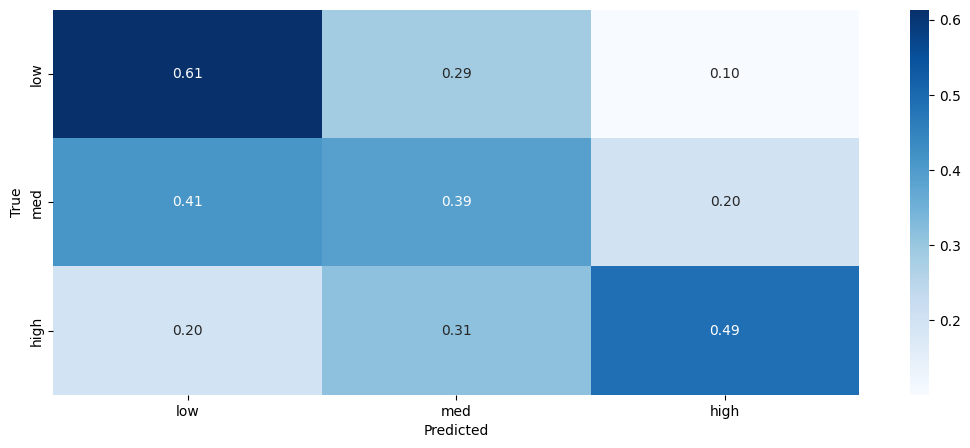

In [ ]:
conf_mat = confusion_matrix(Y_test, y_pred, labels=["low", "med", "high"], normalize = 'true')

seaborn.heatmap(conf_mat, xticklabels=["low", "med", "high"], yticklabels=["low", "med", "high"], annot=True, fmt=".2f", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

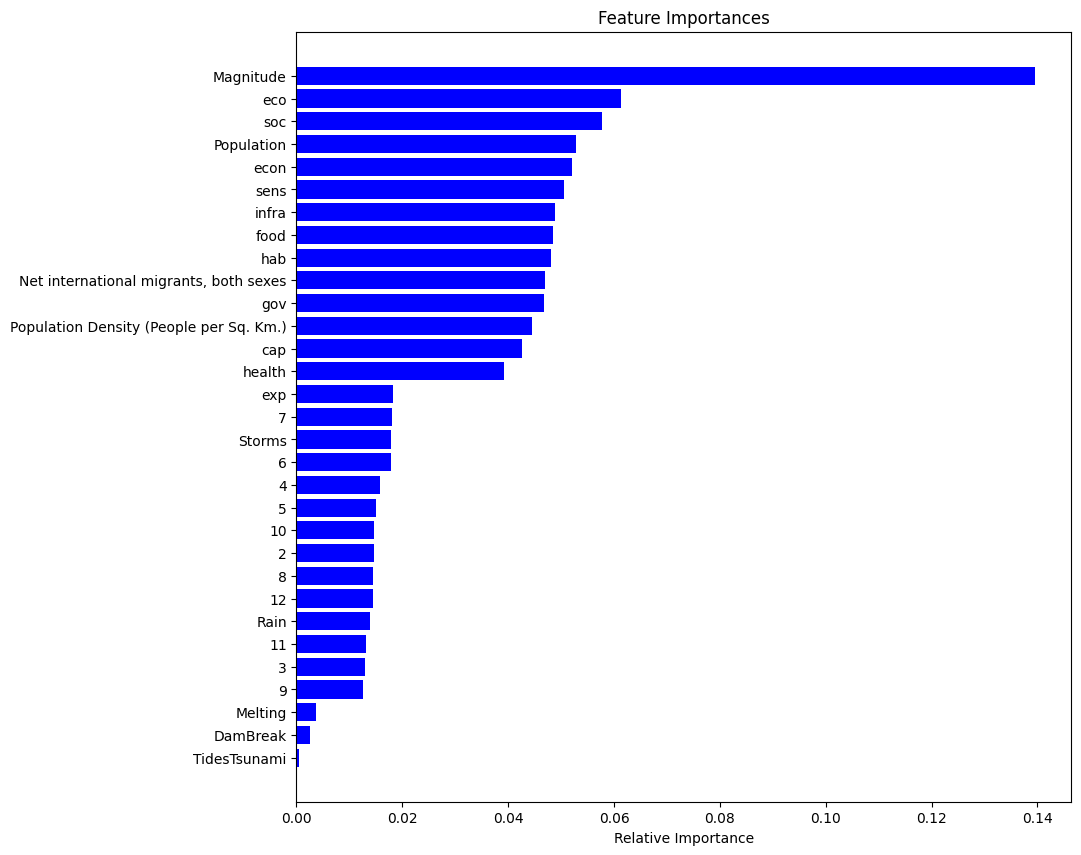

In [ ]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize = (10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Code for random search hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# {'bootstrap': [True, False],
#  'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
#  'max_features': ['auto', 'sqrt'],
#  'min_samples_leaf': [1, 2, 4],
#  'min_samples_split': [2, 5, 10],
#  'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestClassifier()
# # Random search of parameters, using 3 fold cross validation,
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, Y_train)

# y_pred = rf_random.predict(X_test)

# accuracy = accuracy_score(Y_test, y_pred)
# print("Accuracy:", accuracy)

# rf_random.get_params()

# code for exporting tree png

In [ ]:
#Export the first three decision trees from the forest

# for i in range(3):
#     tree = rf.estimators_[i]
#     dot_data = export_graphviz(tree,
#                                feature_names=pd.DataFrame(X_train).columns,
#                                filled=True,
#                                max_depth=None,
#                                impurity=False,
#                                proportion=True)
#     graph = graphviz.Source(dot_data)
#     display(graph)
# graph = graphviz.Source(dot_data)
# graph.render("full_decision_tree", format="png")

In [ ]:
#

# Med/High class model

In [ ]:
cat.shape

(2622, 32)

In [ ]:
specat = cat[cat['binnedIDPs'] != 'low']
specat.shape

(1747, 32)

In [ ]:
for col in specat.columns:
  print(col, end=' | ')

econ | gov | soc | cap | eco | exp | food | hab | health | infra | sens | Magnitude | Population | Population Density (People per Sq. Km.) | Net international migrants, both sexes | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | Storms | DamBreak | Rain | Melting | TidesTsunami | binnedIDPs | 

In [ ]:
#specat = specat.drop(columns = [2,3,4,5,6,7,8,9,10,11,12,'Rain','Storms','Melting','DamBreak','TidesTsunami'])

In [ ]:
X = specat.iloc[:, :-1]
Y = specat.iloc[:, specat.shape[1]-1]

X= X.rename(str,axis="columns")

In [ ]:
# Split dataset into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
# Print shapes of each
print('Training input:', X_train.shape)
print('Testing input:', X_test.shape)
print('Training output:', Y_train.shape)
print('Testing output:', Y_test.shape)

Training input: (1397, 31)
Testing input: (350, 31)
Training output: (1397,)
Testing output: (350,)


In [ ]:
rf = RandomForestClassifier(random_state = 100)
rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.64


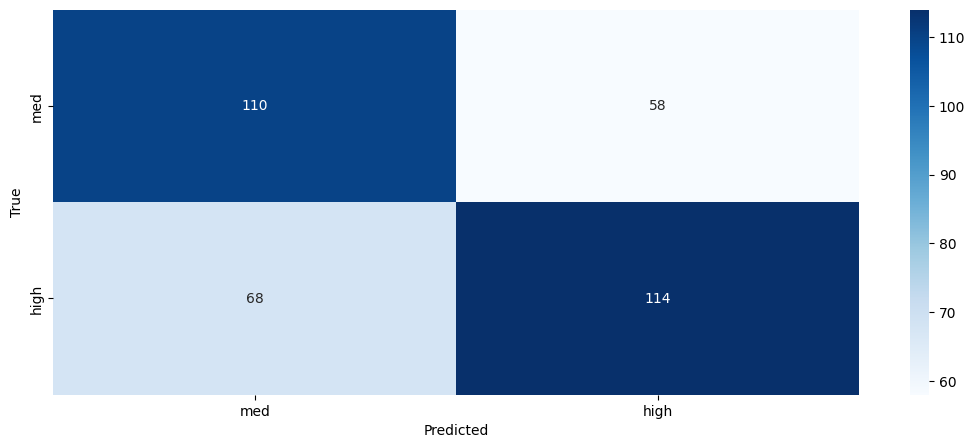

In [ ]:
conf_mat = confusion_matrix(Y_test, y_pred, labels=["med", "high"])

seaborn.heatmap(conf_mat, xticklabels=["med", "high"], yticklabels=["med", "high"], annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

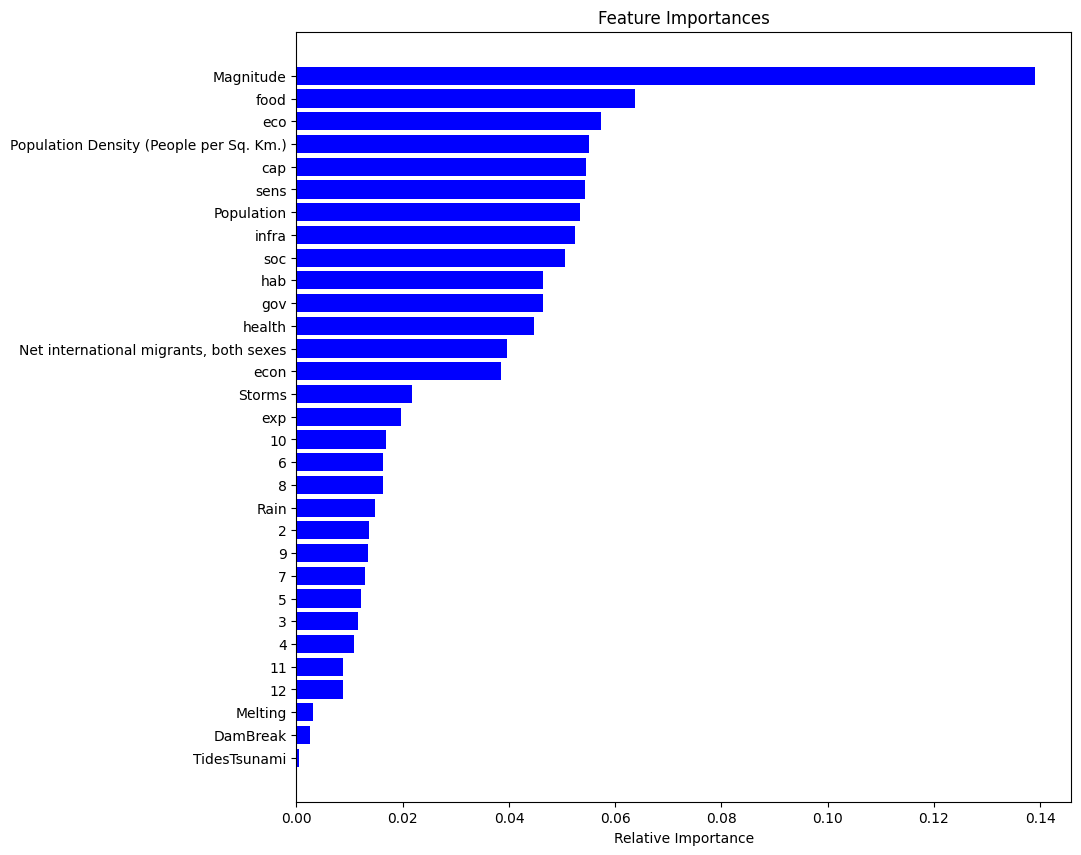

In [ ]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize = (10,10))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
clf = LogisticRegression()
clf.fit(X_train, Y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.6342857142857142


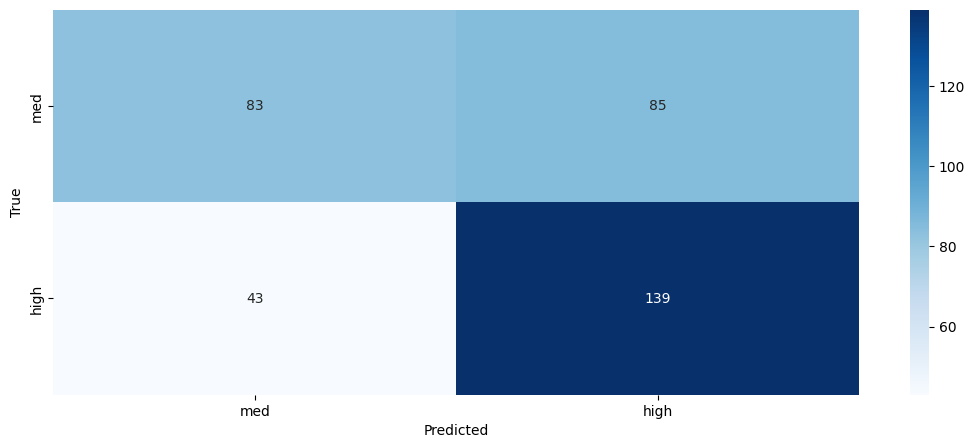

In [ ]:
conf_mat = confusion_matrix(Y_test, y_pred, labels=["med", "high"])

seaborn.heatmap(conf_mat, xticklabels=["med", "high"], yticklabels=["med", "high"], annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pipe.fit(X_train, Y_train)
y_pred = pipe.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)

print("Accuracy:", accuracy)

Accuracy: 0.6628571428571428


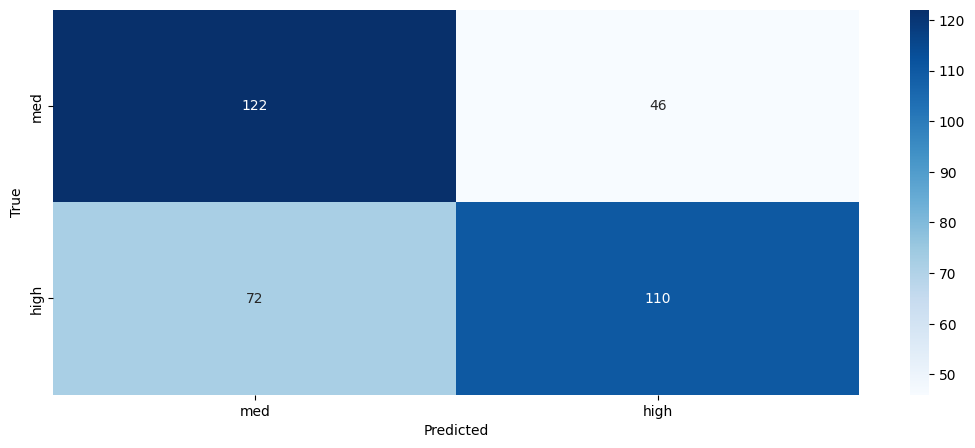

In [ ]:
conf_mat = confusion_matrix(Y_test, y_pred, labels=["med", "high"])

seaborn.heatmap(conf_mat, xticklabels=["med", "high"], yticklabels=["med", "high"], annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

so ensemble model will:

- for each row,
>- predict with base model
>- if prediction is "low",
>>- keep pred
>- if prediction is "med",
>>- predict with model that has best accuracy for med class
>- if prediction is "high",
>>- predict with model that has best accuracy for high class

In [ ]:
def ensemble(data):
  X_full = data.iloc[:, :-1]
  Y_full = data.iloc[:, data.shape[1]-1]
  X_full = X_full.rename(str,axis="columns")
  Xf_train, Xf_test, Yf_train, Yf_test = train_test_split(X_full, Y_full, test_size=0.2, random_state=1)

  sdata = data[data['binnedIDPs'] != 'low']
  X_small = data.iloc[:, :-1]
  Y_small = data.iloc[:, data.shape[1]-1]
  X_small = X_small.rename(str,axis="columns")
  Xs_train, Xs_test, Ys_train, Ys_test = train_test_split(X_small, Y_small, test_size=0.2, random_state=1)

  rff = RandomForestClassifier(random_state = 100)
  rff.fit(Xf_train.values, Yf_train.values)
  rfs = LogisticRegression(random_state = 100)
  rfs.fit(Xs_train.values, Ys_train.values)
  y_pred = []

  for i, row in Xf_test.iterrows():
    base_pred = rff.predict(row.to_numpy().reshape(1, -1))
    if base_pred == 'low':
      y_pred.append(base_pred)
    else:
      y_pred.append(rfs.predict(row.to_numpy().reshape(1, -1)))

  accuracy = accuracy_score(Yf_test, y_pred)

  return accuracy

ensemble(cat)

0.49333333333333335